# ch 16_10 vector auto regressive 

이전 챕터에서 두 시계열 데이터 사이에 인과관계가 있는지 여부를 검정하는 Granger Causality Test에 대해서 배웠습니다. 이 때, Y를 예측할 때, X의 과거 데이터를 피쳐로 사용하는 모델을 소개했습니다. 그리고 만약 X의 과거 데이터가 Y값을 예측하는데 도움이 된다면 회귀 계수가 0이 아닐 것이라고 가설 검정을 진행했습니다.

$$y_{t}=\alpha+\sum_{j=1}^{p}\beta_{j}y_{t-j}+\sum_{j=1}^{r}\gamma_{j}x_{t-j}+\epsilon_{t}$$

Granger Causality Test 결과, 평균 기온이 전력 소요량을 예측하는데 도움이 된다고 결론이 내려졌다면 어떨까요? 전력 소요량 예측 모델을 만들 때, 평균 기온도 모델에 포함시키면 좋지 않을까요? 이 때, 사용할 수 있는 모델이 vector auto regressive 모델입니다.

##  데이터 셋 준비

In [154]:
from utils import load_power, plot_multiple_timeseries 

train_df, test_df = load_power()

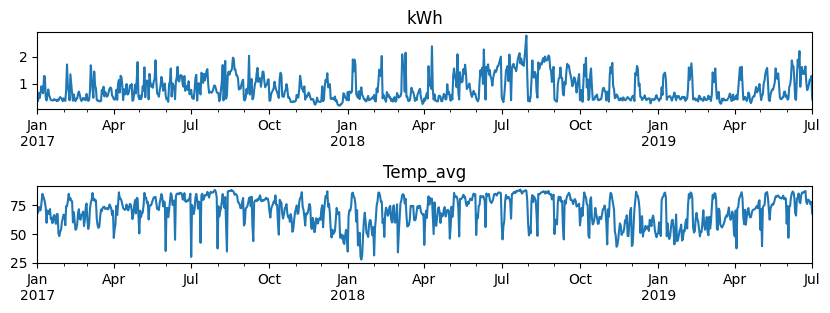

In [155]:
plot_multiple_timeseries(train_df, ["kWh", "Temp_avg"])

### 정상성 테스트

### 계절성 확인

kWh와 Temp_avg의 acf plot을 그려서 계절성 주기를 확인해보면 약 30일의 주기를 가지고 있음을 알 수 있습니다.

## AR 모델 학습

비교를 위해서 AR 모델을 먼저 학습시켜 보겠습니다. lag 값은 계절성 주기 만큼 30으로 설정해보겠습니다.

## VAR 모델 학습

이번에는 kWh와 Temp_avg 데이터를 동시에 사용해서 Vector Auto Regressive 모델을 학습시켜 보겠습니다. 이 때, maxlag 값을 fit 함수에 파라미터로 전달하는 부분이 차이가 있습니다.

### 최적의 lag 선택

lag를 증가시켜가면서 model을 fit 시키고, AIC 값이 최소가 되는 지점을 maxlag로 지정하겠습니다.

### Inference 및 Visualize

## 정리

이번 챕터에서는 다른 시계열 데이터를 피쳐로 사용하는 Vector Auto Regressive 모델에 대해서 살펴봤습니다. Vector Auto Regressive 모델은 단일 Auto Regressive 모델에 비해 복잡도가 높고, 성능 향상 효과가 크지 않아서 잘 사용되지 않습니다. 때문에 Vector ARIMA, Vector SARIMA 등의 모델들도 있습니다만, 굳이 다루지는 않고 넘어가겠습니다.